In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

2024-11-28 20:23:18.700468: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 20:23:18.712366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 20:23:18.725928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 20:23:18.729640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 20:23:18.739513: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dataset_dir = './garbage_classification/'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [3]:
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 12415 images belonging to 12 classes.


In [4]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_generator = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation split
)

Found 3100 images belonging to 12 classes.


In [5]:
dim = 150  # Input image dimensions
classes = list(train_generator.class_indices.keys())  # Class labels
initial_learning_rate = 1e-4
epochs_1 = 30
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size


In [6]:
classes

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [7]:
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))
conv_base.trainable = False 

I0000 00:00:1732814602.218838   49920 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732814602.243394   49920 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732814602.243570   49920 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732814602.244610   49920 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D


In [9]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(len(classes), activation='softmax')  # Output layer for classification
])


In [10]:
from tensorflow.keras import  optimizers


In [11]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        12,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,049,804 (26.89 MB)

 Trainable params: 12,300 (48.05 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [13]:
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10
    return lr * drop_rate if (epoch % epochs_drop == 0 and epoch > 0) else lr

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_1,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)]  # Optional learning rate scheduler
)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30


/home/stonie/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732814613.461411   50327 service.cc:146] XLA service 0x79e7e4001380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732814613.461431   50327 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-28 20:23:33.787276: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 20:23:35.517733: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907

  3/387 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.1736 - loss: 3.9439   

I0000 00:00:1732814627.682824   50327 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2268 - loss: 3.4938

2024-11-28 20:24:47.787956: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3304', 140 bytes spill stores, 140 bytes spill loads



387/387 ━━━━━━━━━━━━━━━━━━━━ 88s 170ms/step - accuracy: 0.2270 - loss: 3.4924 - val_accuracy: 0.5179 - val_loss: 1.5686 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/30
  1/387 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.3438 - loss: 2.2035

2024-11-28 20:24:53.274946: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-28 20:24:53.275094: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/stonie/miniconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-28 20:24:54.938536: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3304', 180 bytes spill stores, 180 bytes spill loads



387/387 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.3438 - loss: 2.2035 - val_accuracy: 0.6071 - val_loss: 1.4256 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/30


2024-11-28 20:25:06.102958: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


387/387 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.4495 - loss: 2.0301 - val_accuracy: 0.6615 - val_loss: 1.0673 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - accuracy: 0.5938 - loss: 1.8833 - val_accuracy: 0.6786 - val_loss: 1.0497 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/30


2024-11-28 20:25:53.687047: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


387/387 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.5720 - loss: 1.4762 - val_accuracy: 0.7220 - val_loss: 0.8580 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 6/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.5312 - loss: 1.3445 - val_accuracy: 0.7143 - val_loss: 0.8417 - learning_rate: 1.0000e-04

Epoch 7: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 7/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.6459 - loss: 1.1987 - val_accuracy: 0.7617 - val_loss: 0.7267 - learning_rate: 1.0000e-04

Epoch 8: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 8/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.7812 - loss: 1.0025 - val_accuracy: 0.8214 - val_loss: 0.6217 - learning_rate: 1.0000e-04

Epoch 9: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 9/30


2024-11-28 20:27:28.865516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13920253089720153675
2024-11-28 20:27:28.904650: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


387/387 ━━━━━━━━━━━━━━━━━━━━ 48s 123ms/step - accuracy: 0.6934 - loss: 1.0080 - val_accuracy: 0.7760 - val_loss: 0.6682 - learning_rate: 1.0000e-04

Epoch 10: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 10/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 119us/step - accuracy: 0.7500 - loss: 0.8342 - val_accuracy: 0.8214 - val_loss: 0.7128 - learning_rate: 1.0000e-04

Epoch 11: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 11/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.7269 - loss: 0.9025 - val_accuracy: 0.7858 - val_loss: 0.6404 - learning_rate: 5.0000e-05

Epoch 12: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 12/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 109us/step - accuracy: 0.7500 - loss: 0.7146 - val_accuracy: 0.7500 - val_loss: 0.6743 - learning_rate: 5.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 13/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms

2024-11-28 20:30:25.661504: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


387/387 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.7570 - loss: 0.7895 - val_accuracy: 0.8014 - val_loss: 0.5765 - learning_rate: 5.0000e-05

Epoch 18: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 18/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 111us/step - accuracy: 0.7500 - loss: 0.7564 - val_accuracy: 0.7857 - val_loss: 0.7068 - learning_rate: 5.0000e-05

Epoch 19: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 19/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.7553 - loss: 0.7767 - val_accuracy: 0.8092 - val_loss: 0.5589 - learning_rate: 5.0000e-05

Epoch 20: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 20/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 110us/step - accuracy: 0.9062 - loss: 0.3676 - val_accuracy: 0.7857 - val_loss: 0.6099 - learning_rate: 5.0000e-05

Epoch 21: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 21/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms

In [15]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

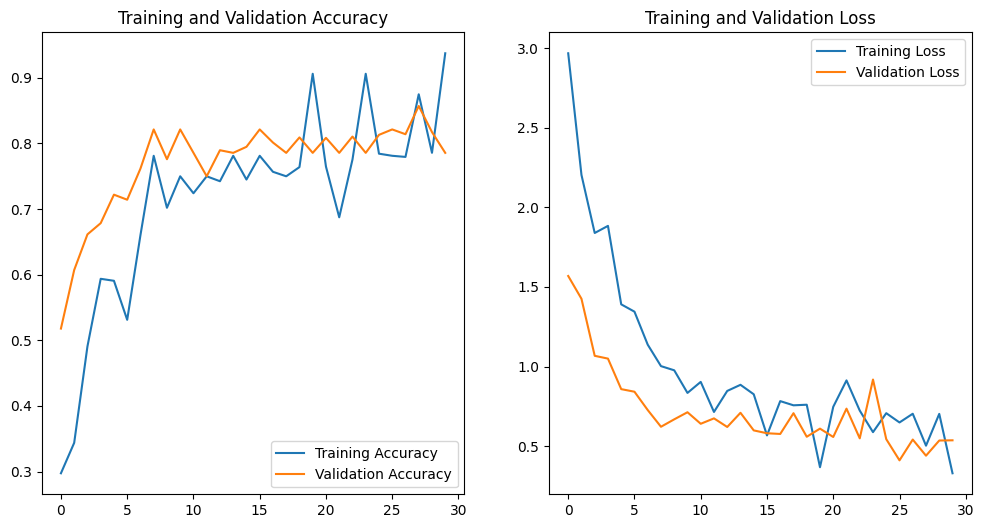

In [16]:
plot_metrics(history)

In [17]:
# Save the model
model.export('waste_sorting_model')


INFO:tensorflow:Assets written to: waste_sorting_model/assets


INFO:tensorflow:Assets written to: waste_sorting_model/assets


Saved artifact at 'waste_sorting_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_427')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  134041428756816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428759504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428758736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428756048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428758160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428757968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428758352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428758544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428757392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041428761040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134041

In [18]:
converter = tf.lite.TFLiteConverter.from_saved_model('waste_sorting_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('waste_sorting_model.tflite', 'wb') as f:
    f.write(tflite_model)

W0000 00:00:1732815372.737676   49920 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1732815372.737707   49920 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-11-28 20:36:12.738090: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: waste_sorting_model
2024-11-28 20:36:12.761075: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-28 20:36:12.761108: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: waste_sorting_model
2024-11-28 20:36:13.041586: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-11-28 20:36:13.101973: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-28 20:36:14.955183: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: waste_sorting_model
2024-11-28 20:36:15.416449: I tensorflow/cc/saved_model/

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation split
)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


Found 3100 images belonging to 12 classes.
 3/97 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8194 - loss: 0.4930

/home/stonie/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8181 - loss: 0.5333
Test Accuracy: 0.82


In [20]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Confusion matrix and classification report
print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step
[[ 10  12   4  10  73   4  16  14   8  28   4   6]
 [ 10  16  10   7  64   6  14  18  17  23   9   3]
 [  4   8   7   5  43   4  10   9   6  18   4   3]
 [ 11  12   6   5  65   5  13  13   8  30   3   7]
 [ 54  63  26  58 413  27  75  77  68 133  36  35]
 [  7   8   1   3  46   3   8  14   8  19   4   4]
 [ 15   9   5   8  46   8  15   7   6  26   6   2]
 [ 11  15   9   6  76   7  15  17  13  30   7   4]
 [  8  11  10   7  72   2   7  13   9  26   3   5]
 [ 26  25  13  14 155  14  26  33  21  40  16  12]
 [  8   6   3   4  59   6   9  12   5  21   4   2]
 [  8   7   4   3  43   5  17  12  13  29   4  10]]
              precision    recall  f1-score   support

     battery       0.06      0.05      0.06       189
  biological       0.08      0.08      0.08       197
 brown-glass       0.07      0.06      0.06       121
   cardboard       0.04      0.03      0.03       178
     clothes       0.36      0.39      0.37      1065
 green-glass       0.

In [21]:
def display_predictions(generator, model, num_images=9):
    x_batch, y_batch = next(generator)
    predictions = model.predict(x_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_batch, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
        true_label = list(generator.class_indices.keys())[true_classes[i]]
        predicted_label = list(generator.class_indices.keys())[predicted_classes[i]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


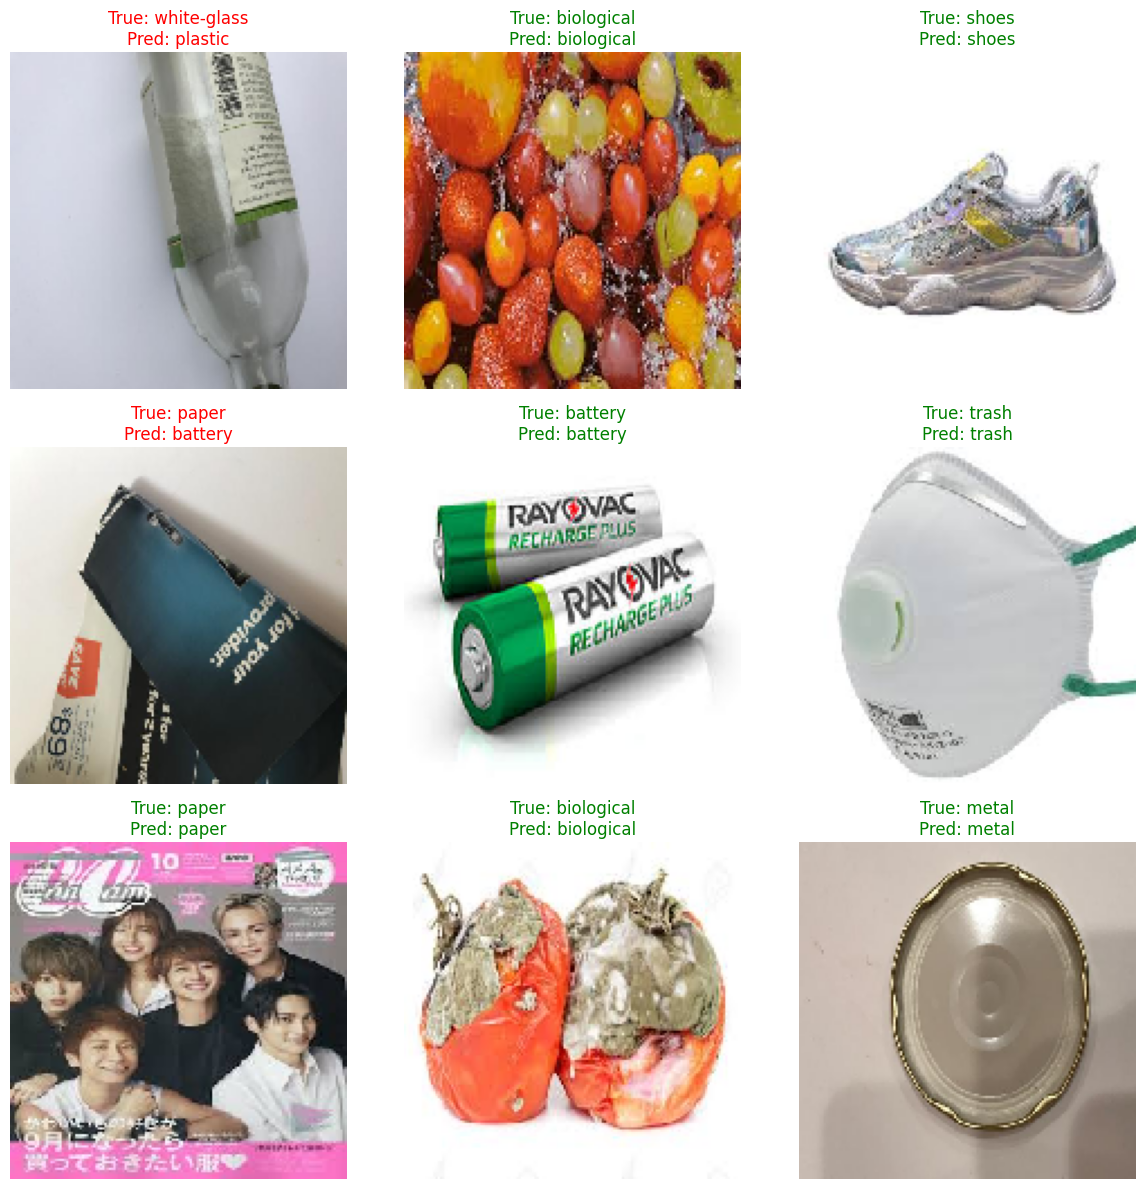

In [22]:
display_predictions(val_generator, model)


In [23]:
def plot_confusion_matrix(y_true, y_pred_classes, class_labels):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


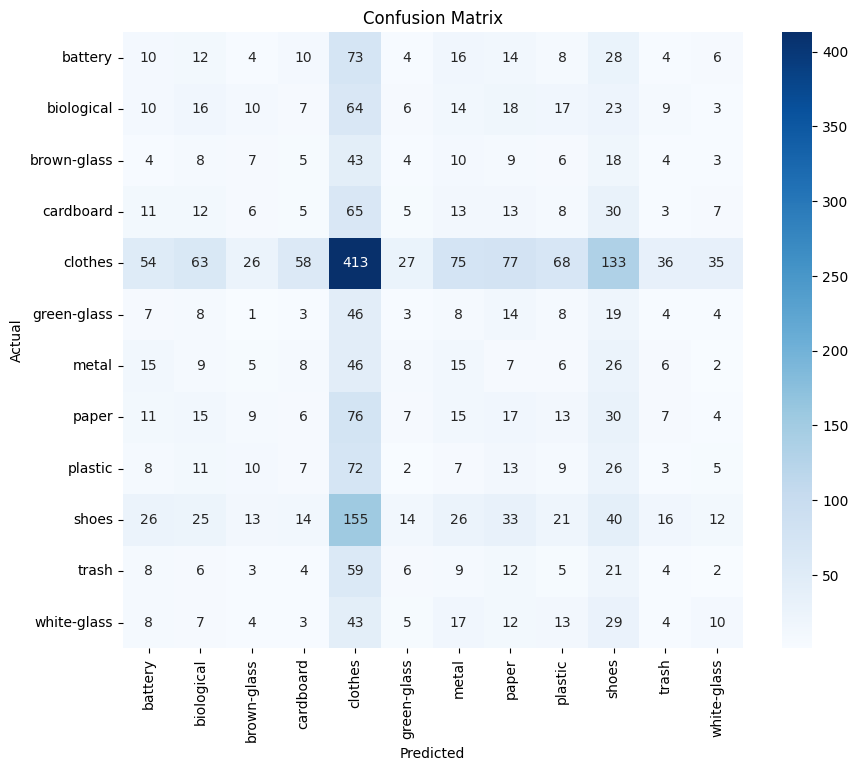

In [24]:
plot_confusion_matrix(y_true, y_pred_classes, list(val_generator.class_indices.keys()))
